# v1

Morbidelli model with manually-input protein mass and net charge, along with resin ligand density

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, stats


from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
import multiprocessing as mp


In [25]:
sys.path.append("./mean_field_electrostatics/v1/")

import charged_objects as obj
import m_functions as m_fun

# Plotting functions

In [26]:
def instantiate_fig(x=7, y=6):
    fig, ax = plt.subplots()
    fig.set_size_inches(x, y, forward=True)
    font = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    return fig, ax

def set_layout(fig, ax, legend=False):
    if legend:
        ax.legend(loc='best', handlelength=1, frameon=False)
    fig.patch.set_alpha(1)
    plt.tight_layout()
    return

# Morbidelli model
## Example

In [27]:
def get_is_for_kprime_res(ion_str, kprime_target, surf_area, porosity, dpr, apr, protein, resin):
    solution = obj.solution(pH=7.0, ion_str=ion_str, eps=80.1)
    kprime   = m_fun.m_get_kprime(surf_area, porosity, dpr, apr, solution, protein, resin)
    return abs(np.log10(kprime) - np.log10(kprime_target))

def get_is_for_kprime(args):
    fit = optimize.minimize_scalar(get_is_for_kprime_res, args=args)
    assert fit.success
    return fit.x

def get_nu_alpha(is_vals, k_targets):
    is_vals     = np.array(is_vals)
    kprime_vals = np.array(k_targets)
    log_is      = np.log(is_vals)
    log_kprime  = np.log(kprime_vals)

    nu = -1.0*(log_kprime[0] - log_kprime[1])/(log_is[0] - log_is[1])
    phi_alpha = kprime_vals[0]/((is_vals[0]*1e3)**(-1.0*nu))
    return nu, phi_alpha

In [28]:
dpr       = 2.0e-10 # resting distance, m
apr       = 8.1e-21 # Hamaker constant, J/mol
surf_area = 1.0e6   # accessible surface area, m-1, maybe use 1e7
porosity  = 0.7     # accessible particle porosity

resin    = obj.resin(name='Example resin', ligand='sulfonate', surf_dens=3.413e-6) 
protein  = obj.protein(name='Example protein', mass=14300, net_charge=9)

k_targets = [100, 0.1]
is_vals =[]
for k_target in k_targets:
    args = (k_target, surf_area, porosity, dpr, apr, protein, resin)
    is_val = get_is_for_kprime(args)
    is_vals.append(is_val)

nu, phi_alpha = get_nu_alpha(is_vals, k_targets)

./mean_field_electrostatics/charged_objects.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  num   = 1 - 1/kap_r + (1 + 1/kap_r)*np.exp(-2.0*kap_r)
./mean_field_electrostatics/charged_objects.py:154: RuntimeWarning: invalid value encountered in double_scalars
  num   = 1 - 1/kap_r + (1 + 1/kap_r)*np.exp(-2.0*kap_r)
./mean_field_electrostatics/charged_objects.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  denom = 1 + 1/kap_r - (1 + 1/kap_r)*np.exp(-2.0*kap_r)     # 2016 Guelat:  1/kap_r is (+) {agrees with Hsu and Liu 2009};        2012 Guelat:  1/kap_r is (-)
./mean_field_electrostatics/charged_objects.py:155: RuntimeWarning: invalid value encountered in double_scalars
  denom = 1 + 1/kap_r - (1 + 1/kap_r)*np.exp(-2.0*kap_r)     # 2016 Guelat:  1/kap_r is (+) {agrees with Hsu and Liu 2009};        2012 Guelat:  1/kap_r is (-)
./mean_field_electrostatics/charged_objects.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  s

In [29]:
is_vals_demo     = np.logspace(np.log10(0.03), np.log10(0.5), 25)
kprime_vals_demo = []
for is_val in is_vals_demo:
    solution = obj.solution(pH=7.0, ion_str=is_val, eps=80.1)
    kprime   = m_fun.m_get_kprime(surf_area, porosity, dpr, apr, solution, protein, resin)
    kprime_vals_demo.append(kprime)

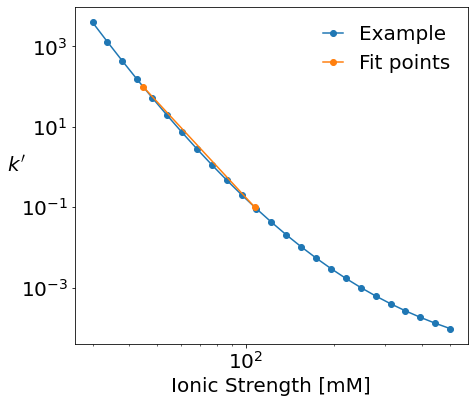

In [30]:
fig, ax = instantiate_fig()
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel('$k\'$', rotation=0)

ax.loglog(is_vals_demo*1e3, kprime_vals_demo, 'o-', label='Example')
ax.loglog(np.array(is_vals)*1e3, k_targets, 'o-', label='Fit points')
set_layout(fig, ax, legend=True)
# fig.savefig(f'./images/mean_field_electrostatics/fit_region_negative_sign.png', dpi=300)

# Varying parameters


In [14]:
def run(args):
    mass, net_charge, surf_dens = args
    dpr       = 2.0e-10 # resting distance, m
    apr       = 8.1e-21 # Hamaker constant, J/mol
    surf_area = 1.0e6   # accessible surface area, m-1, maybe use 1e7
    porosity  = 0.7     # accessible particle porosity

    resin    = obj.resin(name='Example resin', ligand='sulfonate', surf_dens=surf_dens) # 3.413e-6
    protein  = obj.protein(name='Example protein', mass=mass, net_charge=net_charge)

    k_targets = [100, 0.1]
    is_vals =[]
    for k_target in k_targets:
        args_1 = (k_target, surf_area, porosity, dpr, apr, protein, resin)
        is_val = get_is_for_kprime(args_1)
        is_vals.append(is_val)

    nu, phi_alpha = get_nu_alpha(is_vals, k_targets)
    results = [mass, net_charge, surf_dens, nu, phi_alpha]
    return results

In [15]:
## All
# masses = np.concatenate((np.linspace(500, 5000, 11), np.logspace(np.log10(6000), np.log10(250000), 5)))
# charges = np.arange(1, 81, 1)
# surf_densities = [2e-6, 3e-6, 4e-6]

## More realistic
masses = np.logspace(np.log10(5000), np.log10(200000), 7)
charges = np.arange(1, 31, 1)
surf_densities = [2e-6, 3e-6, 4e-6]

args_list = []
for m in masses:
    for c in charges:
        for s in surf_densities:
            args_list.append((m, c, s))

pool    = mp.Pool(processes = mp.cpu_count()-2)
results = pool.map(run, args_list)
pool.close()
pool.join()

df_model = pd.DataFrame(results, columns=['mass', 'net_charge', 'surf_dens', 'nu', 'phi_alpha'])

./mean_field_electrostatics/charged_objects.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  num   = 1 - 1/kap_r + (1 + 1/kap_r)*np.exp(-2.0*kap_r)
./mean_field_electrostatics/charged_objects.py:154: RuntimeWarning: invalid value encountered in double_scalars
  num   = 1 - 1/kap_r + (1 + 1/kap_r)*np.exp(-2.0*kap_r)
./mean_field_electrostatics/charged_objects.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  denom = 1 + 1/kap_r - (1 + 1/kap_r)*np.exp(-2.0*kap_r)     # 2016 Guelat:  1/kap_r is (+) {agrees with Hsu and Liu 2009};        2012 Guelat:  1/kap_r is (-)
./mean_field_electrostatics/charged_objects.py:155: RuntimeWarning: invalid value encountered in double_scalars
  denom = 1 + 1/kap_r - (1 + 1/kap_r)*np.exp(-2.0*kap_r)     # 2016 Guelat:  1/kap_r is (+) {agrees with Hsu and Liu 2009};        2012 Guelat:  1/kap_r is (-)
./mean_field_electrostatics/charged_objects.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  s

./mean_field_electrostatics/charged_objects.py:154: RuntimeWarning: invalid value encountered in double_scalars
  num   = 1 - 1/kap_r + (1 + 1/kap_r)*np.exp(-2.0*kap_r)
./mean_field_electrostatics/charged_objects.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  self.m_charge_dens_dl = solution.m_z*constants().e*self.m_charge_dens/(constants().kT*constants().eps0*solution.eps*solution.kappa)
./mean_field_electrostatics/charged_objects.py:155: RuntimeWarning: invalid value encountered in double_scalars
  denom = 1 + 1/kap_r - (1 + 1/kap_r)*np.exp(-2.0*kap_r)     # 2016 Guelat:  1/kap_r is (+) {agrees with Hsu and Liu 2009};        2012 Guelat:  1/kap_r is (-)
./mean_field_electrostatics/charged_objects.py:155: RuntimeWarning: invalid value encountered in double_scalars
  denom = 1 + 1/kap_r - (1 + 1/kap_r)*np.exp(-2.0*kap_r)     # 2016 Guelat:  1/kap_r is (+) {agrees with Hsu and Liu 2009};        2012 Guelat:  1/kap_r is (-)
./mean_field_electrostatics/charged_obje

./mean_field_electrostatics/charged_objects.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  denom = 1 + 1/kap_r - (1 + 1/kap_r)*np.exp(-2.0*kap_r)     # 2016 Guelat:  1/kap_r is (+) {agrees with Hsu and Liu 2009};        2012 Guelat:  1/kap_r is (-)
/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
./mean_field_electrostatics/charged_objects.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  num   = 1 - 1/kap_r + (1 + 1/kap_r)*np.exp(-2.0*kap_r)
./mean_field_electrostatics/charged_objects.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  self.m_charge_dens_dl = solution.m_z*constants().e*self.m_charge_dens/(constants().kT*constants().eps0*solution.eps*solution.kappa)
./mean_field_electrostatics/charged_objects.py:155: RuntimeWarning: invalid value encountered in double_scalars
  denom = 1 + 1/kap_r - (1 + 1/kap_r)*np.ex

/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
./mean_field_electrostatics/charged_objects.py:154: RuntimeWarning: invalid value encountered in double_scalars
  num   = 1 - 1/kap_r + (1 + 1/kap_r)*np.exp(-2.0*kap_r)
/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
./mean_field_electrostatics/charged_objects.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  self.m_charge_dens_dl = solution.m_z*constants().e*self.m_charge_dens/(constants().kT*constants().eps0*solution.eps*solution.kappa)
./mean_field_electrostatics/charged_objects.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  self.m_charge_dens_dl = solution.m_z*constants().e*self.m_charge_dens/(constants().kT*constants().eps0*solution.eps*solution.kappa)
./mean_field_electrostatics

./mean_field_electrostatics/charged_objects.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  self.m_charge_dens_dl = solution.m_z*constants().e*self.m_charge_dens/(constants().kT*constants().eps0*solution.eps*solution.kappa)
/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
./mean_field_electrostatics/charged_objects.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  num   = 1 - 1/kap_r + (1 + 1/kap_r)*np.exp(-2.0*kap_r)
./mean_field_electrostatics/charged_objects.py:154: RuntimeWarning: invalid value encountered in double_scalars
  num   = 1 - 1/kap_r + (1 + 1/kap_r)*np.exp(-2.0*kap_r)
/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
./mean_field_electrostatics/charged_objects.py:155: RuntimeWarning: divide by zero encountered in double

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/chase/anaconda3/lib/python3.7/site-

(10.0, 1e+34)

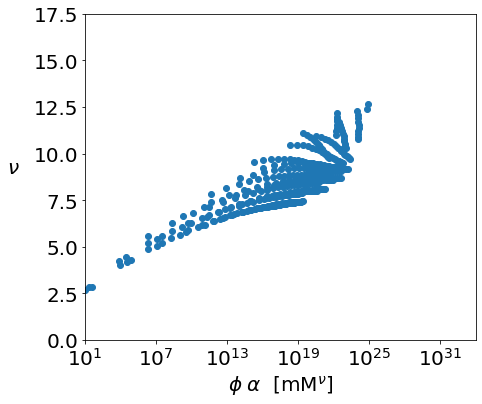

In [16]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \; \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)
ax.set_xscale('log')

ax.plot(df_model.phi_alpha, df_model.nu, 'o')
    
ax.set_ylim(0, 17.5)
ax.set_xlim(1e1, 1e34)

In [17]:
# fig, ax = instantiate_fig()
# ax.set_xlabel(r'$\phi \; \alpha$  [mM$^\nu$]')
# ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)
# ax.set_xscale('log')

# for s in surf_densities:
#     df_temp = df_model[df_model.surf_dens == s]
#     ax.plot(df_temp.phi_alpha, df_temp.nu, 'o')
    
# ax.set_ylim(0, 17.5)
# ax.set_xlim(1e1, 1e34)



# fig, ax = instantiate_fig()
# ax.set_xlabel(r'$\phi \; \alpha$  [mM$^\nu$]')
# ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)
# ax.set_xscale('log')

# for m in masses:
#     df_temp = df_model[df_model.mass == m]
#     ax.plot(df_temp.phi_alpha, df_temp.nu, 'o')
    
# ax.set_ylim(0, 17.5)
# ax.set_xlim(1e1, 1e34)



# fig, ax = instantiate_fig()
# ax.set_xlabel(r'$\phi \; \alpha$  [mM$^\nu$]')
# ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)
# ax.set_xscale('log')

# for c in charges:
#     df_temp = df_model[df_model.net_charge == c]
#     ax.plot(df_temp.phi_alpha, df_temp.nu, 'o')
    
# ax.set_ylim(0, 17.5)
# ax.set_xlim(1e1, 1e34)

## Comparison with data

In [18]:
def my_fit_function_ln_keq_2(tis, a, b):
    return np.log(a*tis**b)

def meta_correlation(a, c, d):
    return c*np.log(a) + d

def get_meta_residuals(x, a_vals, b_vals):
    c = x[0]
    d = x[1]
    return b_vals - (c*np.log(a_vals) + d)

In [19]:
def get_reg_intervals(x, y, alpha=0.05, line_extension=0.0):
    slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment
    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(1.0-alpha/2.0, dof) # Students statistic of interval confidence

    residual = y - y_model
    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # mean squared error
    MSE = 1/n * np.sum( residual**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x)-line_extension, np.max(x)+line_extension, 1000)
    y_line = np.polyval([slope, intercept], x_line)

    # intervals
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  
    pred_err_var = (std_error**2.0) * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))
    
    return x_line, y_line, ci, pi, pred_err_var

def get_pred_err_var(x, y, x_star):
    slope, intercept = np.polyfit(x, y, 1)  
    y_model = np.polyval([slope, intercept], x)  
    residual = y - y_model

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                       
    m = 2                            
    dof = n - m   
    
    pred_err_var = (np.sum(residual**2) / dof) * (1 + 1/n + (x_star - x_mean)**2 / np.sum((x - x_mean)**2))
    return pred_err_var
    
def plot_intervals(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_xscale('log')
    
    color = 'blue'
    ax.plot(np.exp(x), y, 'o', color = 'royalblue')
    ax.plot(np.exp(x_line), y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
#     ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$a$')
    ax.set_yscale('log')
    
    color = 'blue'
    ax.plot(x, np.exp(y), 'o', color = 'royalblue')
    ax.plot(x_line, np.exp(y_line), color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, np.exp(y_line + pi), np.exp(y_line - pi), color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, np.exp(y_line + ci), np.exp(y_line - ci), color = 'skyblue', label = '95% CI')
    ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse_ln(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$ln(a)$')
    
    color = 'blue'
    ax.plot(x, y, 'o', color = 'royalblue')
    ax.plot(x_line, y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
    ax.legend(loc='lower left', fontsize=16)

    return fig, ax

In [20]:
# Load data
df_all_k = pd.read_csv('./lit_data/all_kprime.csv')
df_all_k.fillna(0.0, inplace=True)

df_2_fit_parms = pd.read_csv('./lit_data/two_params_all_data.csv')
resins = list(set(df_2_fit_parms.resin))
resins.sort()

df_2_fit_parms['ln_a'] = np.log(df_2_fit_parms.a)
data = np.zeros((len(df_2_fit_parms), 2))
data[:,0] = df_2_fit_parms.ln_a
data[:,1] = df_2_fit_parms.b

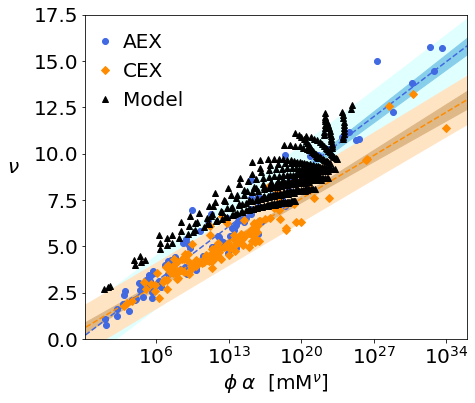

In [22]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \; \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(0, 17.5)

iex_type_list = ['aex', 'cex']
for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = -1*df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)
    
    if iex_type == 'aex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
        marker, fillstyle = 'o', 'full'
    elif iex_type == 'cex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
        marker, fillstyle = 'D', 'full'
    
    ax.plot(np.exp(x), y, marker=marker, fillstyle=fillstyle, linewidth=0, color=color_1, label=iex_type.upper())
    ax.plot(np.exp(x_line), y_line, color=color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color=color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color=color_2)

ax.plot(df_model.phi_alpha, df_model.nu, '^', color='black', label='Model')
    
ax.legend(loc='upper left', handlelength=0.2, frameon=False)
set_layout(fig, ax)
# fig.savefig(f'./images/manuscript_images/consolidated_data_correlation_with_model_negative_sign_second_position.pdf')
fig.savefig(f'./images/mean_field_electrostatics/consolidated_data_correlation_with_model_negative_sign.png', dpi=300)